# Analysis of the styles of beer

We will look at the styles of beer and see if we can find any interesting patterns by checking for each kind of climates, which styles are the most popular.

In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import geopandas as gpd
import seaborn as sns
import spacy
from spacy.language import Language
# from spacy_language_detection import LanguageDetector
import scipy.stats as stats
import wordcloud

from data_loader import (
    get_users_df,
    get_reviews_df,
    get_beers_df,
    get_breweries_df,
    join_breweries_on_beers,
    merge_reviews,
)

In [12]:
us_users_ratings = pd.read_csv("data/us_users_ratings.csv", compression="gzip")

/var/folders/0g/yd41q8010pn2lvl2qx960v240000gn/T/ipykernel_28735/3223522512.py:1: DtypeWarning: Columns (3,11) have mixed types. Specify dtype option on import or set low_memory=False.
  us_users_ratings = pd.read_csv("data/us_users_ratings.csv", compression="gzip")


In [13]:
us_users_ratings = us_users_ratings.dropna(subset=["overall", "general_style"])

Now that the data are loaded, we can first just look at the beers most liked in the whole US:

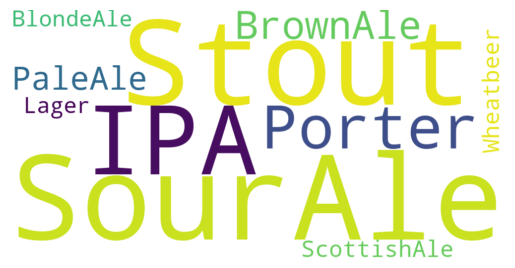

In [28]:
overall_averge_per_beer_type = us_users_ratings.groupby(['general_style'])['overall'].mean().sort_values(ascending=False).reset_index()

# Go through "general_style" column and remove the " "
overall_averge_per_beer_type["general_style"] = overall_averge_per_beer_type["general_style"].str.replace(" ", "")

# Combine the strings into one text
text_combined = " ".join(overall_averge_per_beer_type["general_style"])

# Create and generate a word cloud image:
wordcloud_best_beers = wordcloud.WordCloud(
    width=1000, height=500, background_color="white"
).generate(text_combined)

# Display the generated image:
plt.imshow(wordcloud_best_beers, interpolation="bilinear")
plt.axis("off")
plt.show()

## 1. How does the climate of a user impact their preference in beer style?

1. What type of beer do users from each climate prefer? Is there significance?
2. What is the most rated beer from each climate? Is it one they dislike or like strongly?
3. Is the alcohol percentage of the preferred beer significant to the respective climates?

First, we will need to preprocess the `us_users_ratings` dataset to add a `general_style` column that is made from the beer's `style` which can be very specific. Then, we need to group the beers by climate to do the analysis to find answers to our questions.  

In [10]:
us_users_ratings.head()

,beer_id,date,user_name,user_id,appearance,aroma,palate,taste,overall,rating,...,brewery_nbr_beers_ba,brewery_nbr_beers_rb,user_location,user_nbr_ratings,nbr_ratings,climate,climate_scheme,climate_precipitation,climate_temperature,general_style
7,19827,1360753200,brewdude1982,brewdude1982.691169,4.25,4.50,3.25,3.75,3.75,3.91,...,5,5,North Carolina,264.0,137,Cfa,Temperate,without dry season,hot summer,Pale Ale
8,19827,1357729200,AgentMunky,agentmunky.409755,4.00,3.75,3.50,3.50,3.75,3.64,...,5,5,New York,2314.0,137,Cfa,Temperate,without dry season,hot summer,Pale Ale
11,19827,1353150000,ferrari29,ferrari29.320392,3.00,3.50,2.50,2.50,2.50,2.77,...,5,5,Illinois,585.0,137,Dfa,Continental,without dry season,hot summer,Pale Ale
13,19827,1342260000,OtherShoe2,othershoe2.233642,4.00,3.50,4.00,3.50,4.00,3.68,...,5,5,Massachusetts,1315.0,137,Dfa,Continental,without dry season,hot summer,Pale Ale
14,19827,1335607200,brentk56,brentk56.6284,4.50,3.00,3.50,2.50,2.50,2.84,...,5,5,North Carolina,6306.0,137,Cfa,Temperate,without dry season,hot summer,Pale Ale


As there are many different styles of beer, it seems too hard to automate the process of tokenisation. We chose to export the dataframe with the style of beer and manually assign each one to a more general style. The groupings were made based on this reference: https://hospitalityinsights.ehl.edu/beer-types. These are:
- Lager
- Pale Ale
- Blonde Ale
- Brown Ale
- IPA
- Wheatbeer
- Porter
- Stout
- Sour Ale
- Scottish Ale

In [17]:
# get all styles of beers to regroup them by general types

beer_styles = us_users_ratings[["style"]].copy()
beer_styles = beer_styles.drop_duplicates()
# beer_styles.to_excel(r'beer_style.xlsx', index=False)

print("There are {} different beer styles in the dataset".format(len(beer_styles)))
beer_styles.head()

There are 104 different beer styles in the dataset


,style
0,English Pale Ale
70,English Bitter
127,English India Pale Ale (IPA)
166,American Double / Imperial IPA
167,American Amber / Red Ale


In [32]:
general_beer_types = us_users_ratings["general_style"].unique()

print("There are {} different general beer styles in the dataset".format(len(general_beer_types)))
print(general_beer_types)
us_users_ratings.head()

There are 10 different general beer styles in the dataset
['Pale Ale' 'IPA' 'Porter' 'Blonde Ale' 'Scottish Ale ' 'Lager'
 'Wheat beer' 'Sour Ale' 'Stout' 'Brown Ale']


,beer_id,date,user_name,user_id,appearance,aroma,palate,taste,overall,rating,...,brewery_nbr_beers_ba,brewery_nbr_beers_rb,user_location,user_nbr_ratings,nbr_ratings,climate,climate_scheme,climate_precipitation,climate_temperature,general_style
7,19827,1360753200,brewdude1982,brewdude1982.691169,4.25,4.50,3.25,3.75,3.75,3.91,...,5,5,North Carolina,264.0,137,Cfa,Temperate,without dry season,hot summer,Pale Ale
8,19827,1357729200,AgentMunky,agentmunky.409755,4.00,3.75,3.50,3.50,3.75,3.64,...,5,5,New York,2314.0,137,Cfa,Temperate,without dry season,hot summer,Pale Ale
11,19827,1353150000,ferrari29,ferrari29.320392,3.00,3.50,2.50,2.50,2.50,2.77,...,5,5,Illinois,585.0,137,Dfa,Continental,without dry season,hot summer,Pale Ale
13,19827,1342260000,OtherShoe2,othershoe2.233642,4.00,3.50,4.00,3.50,4.00,3.68,...,5,5,Massachusetts,1315.0,137,Dfa,Continental,without dry season,hot summer,Pale Ale
14,19827,1335607200,brentk56,brentk56.6284,4.50,3.00,3.50,2.50,2.50,2.84,...,5,5,North Carolina,6306.0,137,Cfa,Temperate,without dry season,hot summer,Pale Ale


We will first look for each climate which are the most liked beers (according to the score `overall` given by the users) and which beers are the most reviewed.

In [42]:
# Find for each climate the most liked beer style
climate_beer_type = us_users_ratings.groupby(["climate", "general_style"])["overall"].mean().reset_index()

# Create a datafram which gives for each climate the general style ordered by the average overall rating
columns = ["climate"] + ["beer_" + str(i) for i in range(1, 11)]

best_beers_per_climate = pd.DataFrame(columns=columns)

for climate in climate_beer_type["climate"].unique():
    best_beers_per_climate.loc[climate] = [climate] + list(
        climate_beer_type[climate_beer_type["climate"] == climate]
        .sort_values(by="overall", ascending=False)["general_style"]
        .values[:10]
    )

display(best_beers_per_climate)

# Can compute average position for each beer type in the top 10 for each climate
best_beers_average_position = {}

for row in best_beers_per_climate.iterrows():
    for i, beer in enumerate(row[1][1:]):
        if beer in best_beers_average_position:
            best_beers_average_position[beer] += i + 1
        else:
            best_beers_average_position[beer] = i + 1

for beer in best_beers_average_position:
    best_beers_average_position[beer] /= len(best_beers_per_climate)

print("The average position of each beer type in the top 10 for each climate is:")
print(best_beers_average_position)

,climate,beer_1,beer_2,beer_3,beer_4,beer_5,beer_6,beer_7,beer_8,beer_9,beer_10
Bsk,Bsk,Sour Ale,Stout,IPA,Porter,Brown Ale,Scottish Ale,Pale Ale,Blonde Ale,Wheat beer,Lager
Cfa,Cfa,Sour Ale,Stout,IPA,Porter,Brown Ale,Scottish Ale,Pale Ale,Wheat beer,Blonde Ale,Lager
Cfb,Cfb,Sour Ale,Stout,IPA,Porter,Brown Ale,Wheat beer,Pale Ale,Lager,Scottish Ale,Blonde Ale
Csa,Csa,Sour Ale,Stout,IPA,Porter,Brown Ale,Pale Ale,Scottish Ale,Blonde Ale,Wheat beer,Lager
Csb,Csb,Sour Ale,Stout,Porter,IPA,Brown Ale,Scottish Ale,Pale Ale,Wheat beer,Lager,Blonde Ale
Dfa,Dfa,Sour Ale,Stout,IPA,Porter,Brown Ale,Pale Ale,Wheat beer,Blonde Ale,Scottish Ale,Lager
Dfb,Dfb,Sour Ale,Stout,IPA,Porter,Brown Ale,Pale Ale,Scottish Ale,Wheat beer,Blonde Ale,Lager
Dfc,Dfc,Sour Ale,Stout,Porter,IPA,Brown Ale,Scottish Ale,Wheat beer,Pale Ale,Blonde Ale,Lager
Dsb,Dsb,Sour Ale,Stout,IPA,Porter,Brown Ale,Wheat beer,Pale Ale,Scottish Ale,Blonde Ale,Lager
Dsc,Dsc,Sour Ale,Stout,IPA,Porter,Brown Ale,Scottish Ale,Pale Ale,Wheat beer,Blonde Ale,Lager


The average position of each beer type in the top 10 for each climate is:
{'Sour Ale': 1.0, 'Stout': 2.0, 'IPA': 3.2, 'Porter': 3.8, 'Brown Ale': 5.0, 'Scottish Ale ': 7.0, 'Pale Ale': 6.8, 'Blonde Ale': 8.9, 'Wheat beer': 7.6, 'Lager': 9.7}


We repeat but looking at the most reviewed beers.

In [43]:
most_reviewed_per_climate = pd.DataFrame(columns=columns)

for climate in climate_beer_type["climate"].unique():
    # count the number of reviews for each beer type in this climate
    most_reviewed_per_climate.loc[climate] = [climate] + list(
        us_users_ratings[us_users_ratings["climate"] == climate]
        .groupby(["general_style"])
        .size()
        .sort_values(ascending=False)
        .index[:10]
    )

display(most_reviewed_per_climate)

most_reviewed_position = {}

for row in most_reviewed_per_climate.iterrows():
    for i, beer in enumerate(row[1][1:]):
        if beer in most_reviewed_position:
            most_reviewed_position[beer] += i + 1
        else:
            most_reviewed_position[beer] = i + 1

for beer in most_reviewed_position:
    most_reviewed_position[beer] /= len(best_beers_per_climate)
    
print("The average position of each beer type in the top 10 for each climate is:")
print(most_reviewed_position)

,climate,beer_1,beer_2,beer_3,beer_4,beer_5,beer_6,beer_7,beer_8,beer_9,beer_10
Bsk,Bsk,IPA,Pale Ale,Brown Ale,Porter,Stout,Lager,Sour Ale,Wheat beer,Blonde Ale,Scottish Ale
Cfa,Cfa,IPA,Pale Ale,Brown Ale,Porter,Stout,Lager,Sour Ale,Wheat beer,Blonde Ale,Scottish Ale
Cfb,Cfb,IPA,Pale Ale,Brown Ale,Porter,Lager,Stout,Wheat beer,Sour Ale,Blonde Ale,Scottish Ale
Csa,Csa,IPA,Pale Ale,Brown Ale,Porter,Sour Ale,Stout,Lager,Wheat beer,Blonde Ale,Scottish Ale
Csb,Csb,IPA,Pale Ale,Porter,Brown Ale,Lager,Stout,Sour Ale,Wheat beer,Blonde Ale,Scottish Ale
Dfa,Dfa,IPA,Pale Ale,Brown Ale,Porter,Stout,Lager,Sour Ale,Wheat beer,Blonde Ale,Scottish Ale
Dfb,Dfb,IPA,Pale Ale,Brown Ale,Porter,Stout,Lager,Sour Ale,Wheat beer,Blonde Ale,Scottish Ale
Dfc,Dfc,IPA,Pale Ale,Brown Ale,Porter,Stout,Lager,Sour Ale,Wheat beer,Blonde Ale,Scottish Ale
Dsb,Dsb,IPA,Pale Ale,Porter,Brown Ale,Stout,Lager,Sour Ale,Wheat beer,Blonde Ale,Scottish Ale
Dsc,Dsc,IPA,Pale Ale,Porter,Brown Ale,Lager,Stout,Sour Ale,Wheat beer,Blonde Ale,Scottish Ale


The average position of each beer type in the top 10 for each climate is:
{'IPA': 1.0, 'Pale Ale': 2.0, 'Brown Ale': 3.3, 'Porter': 3.7, 'Stout': 5.4, 'Lager': 5.8, 'Sour Ale': 6.9, 'Wheat beer': 7.9, 'Blonde Ale': 9.0, 'Scottish Ale ': 10.0}


Now, let's plot the two:

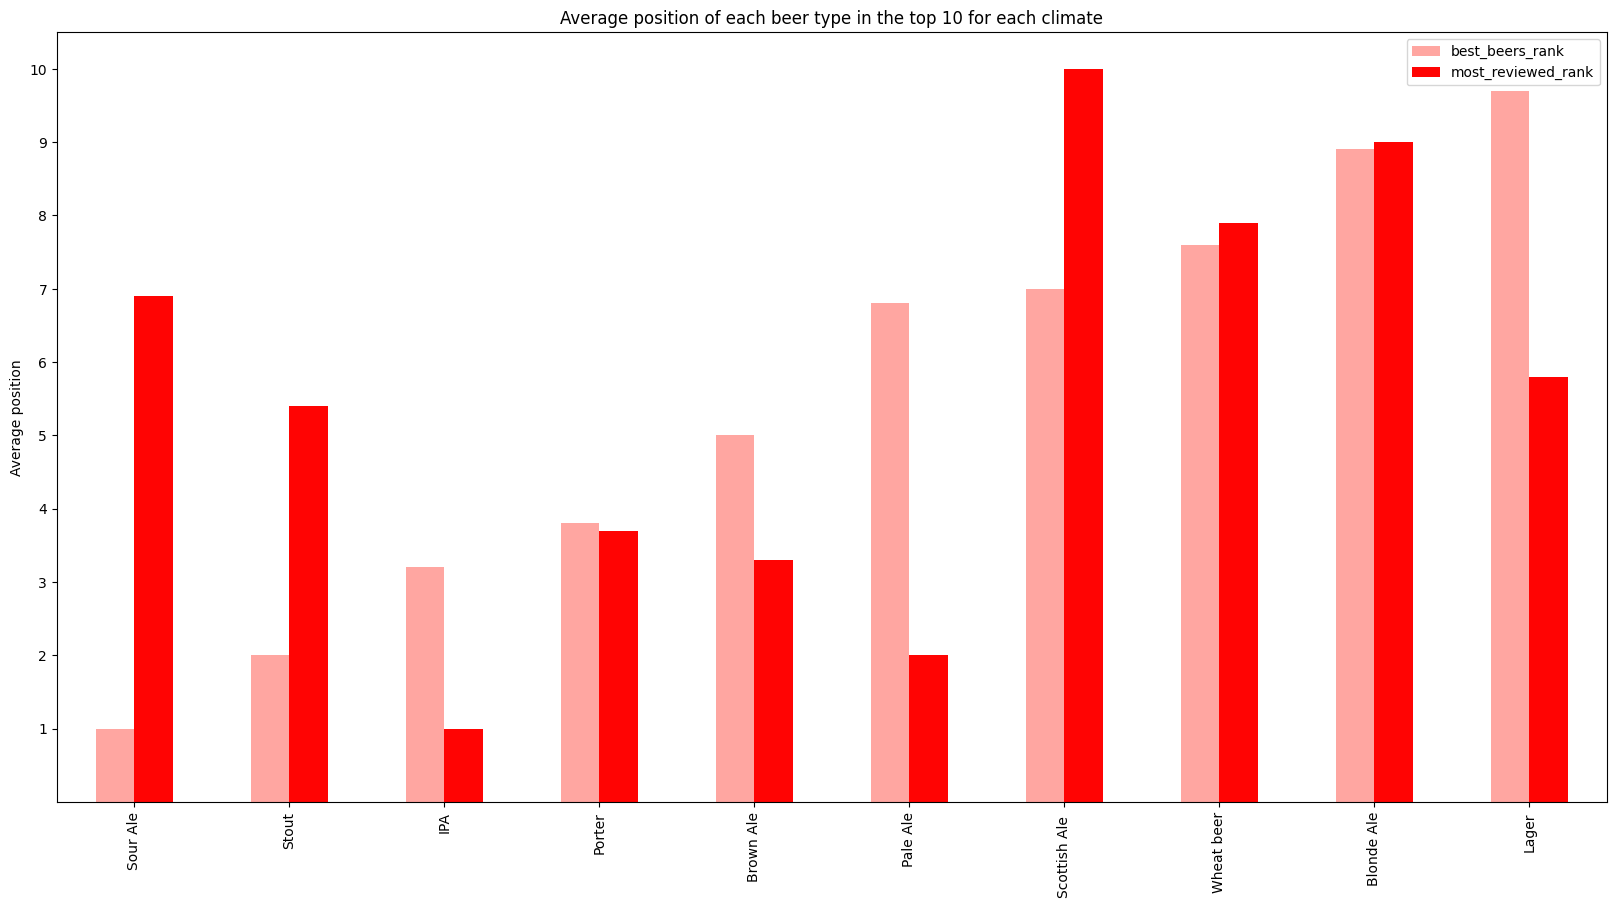

In [62]:
positions_per_beer = pd.DataFrame(columns=["beer_type", "best_beers_rank", "most_reviewed_rank"])

for beer in best_beers_average_position:
    positions_per_beer.loc[beer] = [beer, best_beers_average_position[beer], most_reviewed_position[beer]]
    
positions_per_beer = positions_per_beer.sort_values(by="best_beers_rank", ascending=True)
    
# Plot the two rankings for each beer type using barplot
fig, ax = plt.subplots(figsize=(20, 10))

light_red = "#FFA6A1"
dark_red = "#FF0403"
positions_per_beer.plot.bar(ax=ax, color=[light_red, dark_red])
ax.set_ylabel("Average position")
ax.set_title("Average position of each beer type in the top 10 for each climate")
ax.set_yticks(np.arange(1, 11))
plt.show()

The ordering of the various beers is clearly not the same, but it is interesting to check the actual ratings they got:

<Axes: xlabel='climate', ylabel='general_style'>

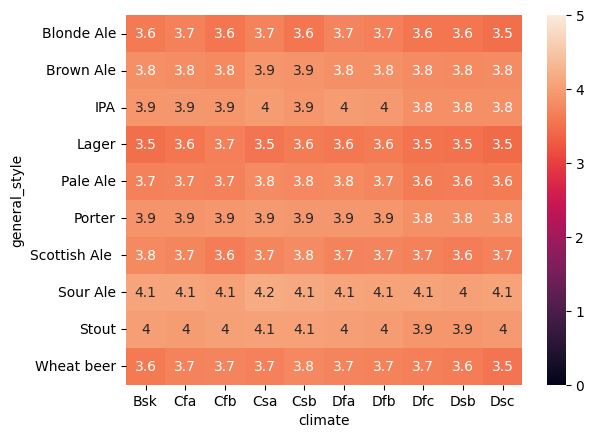

In [54]:
# heatmap of the ratings given to each beer type in each climate

df = pd.crosstab(
    climate_beer_type["general_style"],
    climate_beer_type["climate"],
    values=climate_beer_type["overall"],
    aggfunc="mean",
)
sns.heatmap(df, annot=True, vmin=0, vmax=5)
plt.title("Average rating of each beer type in each climate")
plt.show()

There doesn't seem to be a big difference between the ratings between the climates. There do seem to be types of beers that are generally preferred than others. Let's try to analyse these results in a bit more detail to look for significant differences. For example, the Dsc climate seems to have the most variety in results so we can explore this one first.

/var/folders/0g/yd41q8010pn2lvl2qx960v240000gn/T/ipykernel_28735/803559803.py:11: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plot_1.set_xticklabels(plot_1.get_xticklabels(), rotation=45)
/var/folders/0g/yd41q8010pn2lvl2qx960v240000gn/T/ipykernel_28735/803559803.py:20: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plot_2.set_xticklabels(plot_2.get_xticklabels(), rotation=45)


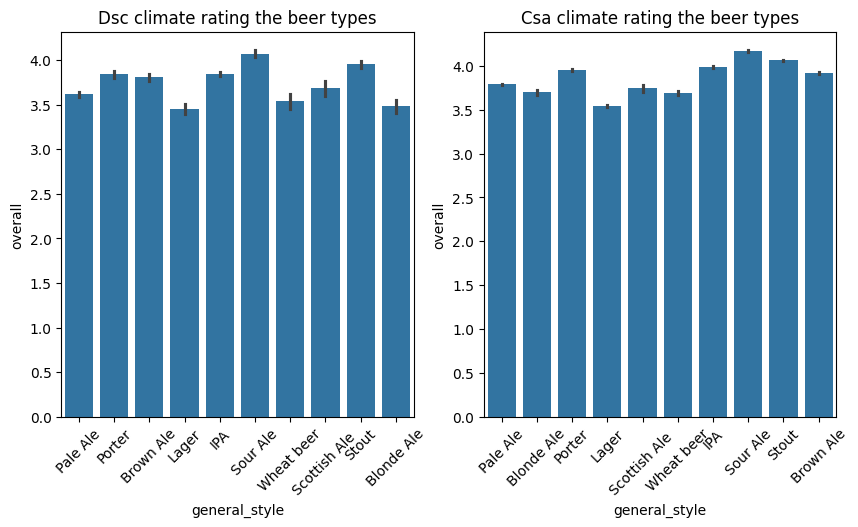

In [63]:
# view the average rating per beer type in Dsc and Csa

fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(10, 5))

plot_1 = sns.barplot(
    x="general_style",
    y="overall",
    data=us_users_ratings[us_users_ratings["climate"] == "Dsc"],
    ax=ax0,
)
plot_1.set_xticklabels(plot_1.get_xticklabels(), rotation=45)
plot_1.set_title("Dsc climate rating the beer types")

plot_2 = sns.barplot(
    x="general_style",
    y="overall",
    data=us_users_ratings[us_users_ratings["climate"] == "Csa"],
    ax=ax1,
)
plot_2.set_xticklabels(plot_2.get_xticklabels(), rotation=45)
plot_2.set_title("Csa climate rating the beer types")

plt.show()

In [64]:
# For each climate, performe a one-way ANOVA test to see if the ratings given to each beer type are significantly different
# H0: the two variables are independent

for climate in us_users_ratings["climate"].unique():
    res = stats.f_oneway(
        *[
            us_users_ratings[us_users_ratings["general_style"] == beer_type]["overall"]
            for beer_type in us_users_ratings["general_style"].unique()
        ]
    )
    
    print("For the climate {}, the p-value is {}".format(climate, res.pvalue))

For the climate Cfa, the p-value is 0.0
For the climate Dfa, the p-value is 0.0
For the climate Cfb, the p-value is 0.0
For the climate Dfb, the p-value is 0.0
For the climate Dfc, the p-value is 0.0
For the climate Csb, the p-value is 0.0
For the climate Csa, the p-value is 0.0
For the climate Dsc, the p-value is 0.0
For the climate Dsb, the p-value is 0.0
For the climate Bsk, the p-value is 0.0


All p-values are below 0.05, so we can reject the null hypothesis and conclude that there is a significant difference between the ratings of the different beers in each climate.

We can now look at the overall score for each beer across all climates:

In [65]:
# Microaverage: compute the mean overall rating for all users
micro_av_overall = us_users_ratings["overall"].mean()
print("The micro average overall rating is {:.4f}".format(micro_av_overall))

# Macroaverage: compute statistics for each climate, then take the mean
climate_av_overall = (
    us_users_ratings.groupby("climate")["overall"]
    .mean()
    .sort_values(ascending=False)
    .reset_index()
)
climate_av_overall.set_index("climate", inplace=True)
macro_av_overall = climate_av_overall["overall"].mean()
print("The macro average overall rating is {:.4f}".format(macro_av_overall))

The micro average overall rating is 3.8582
The macro average overall rating is 3.8342


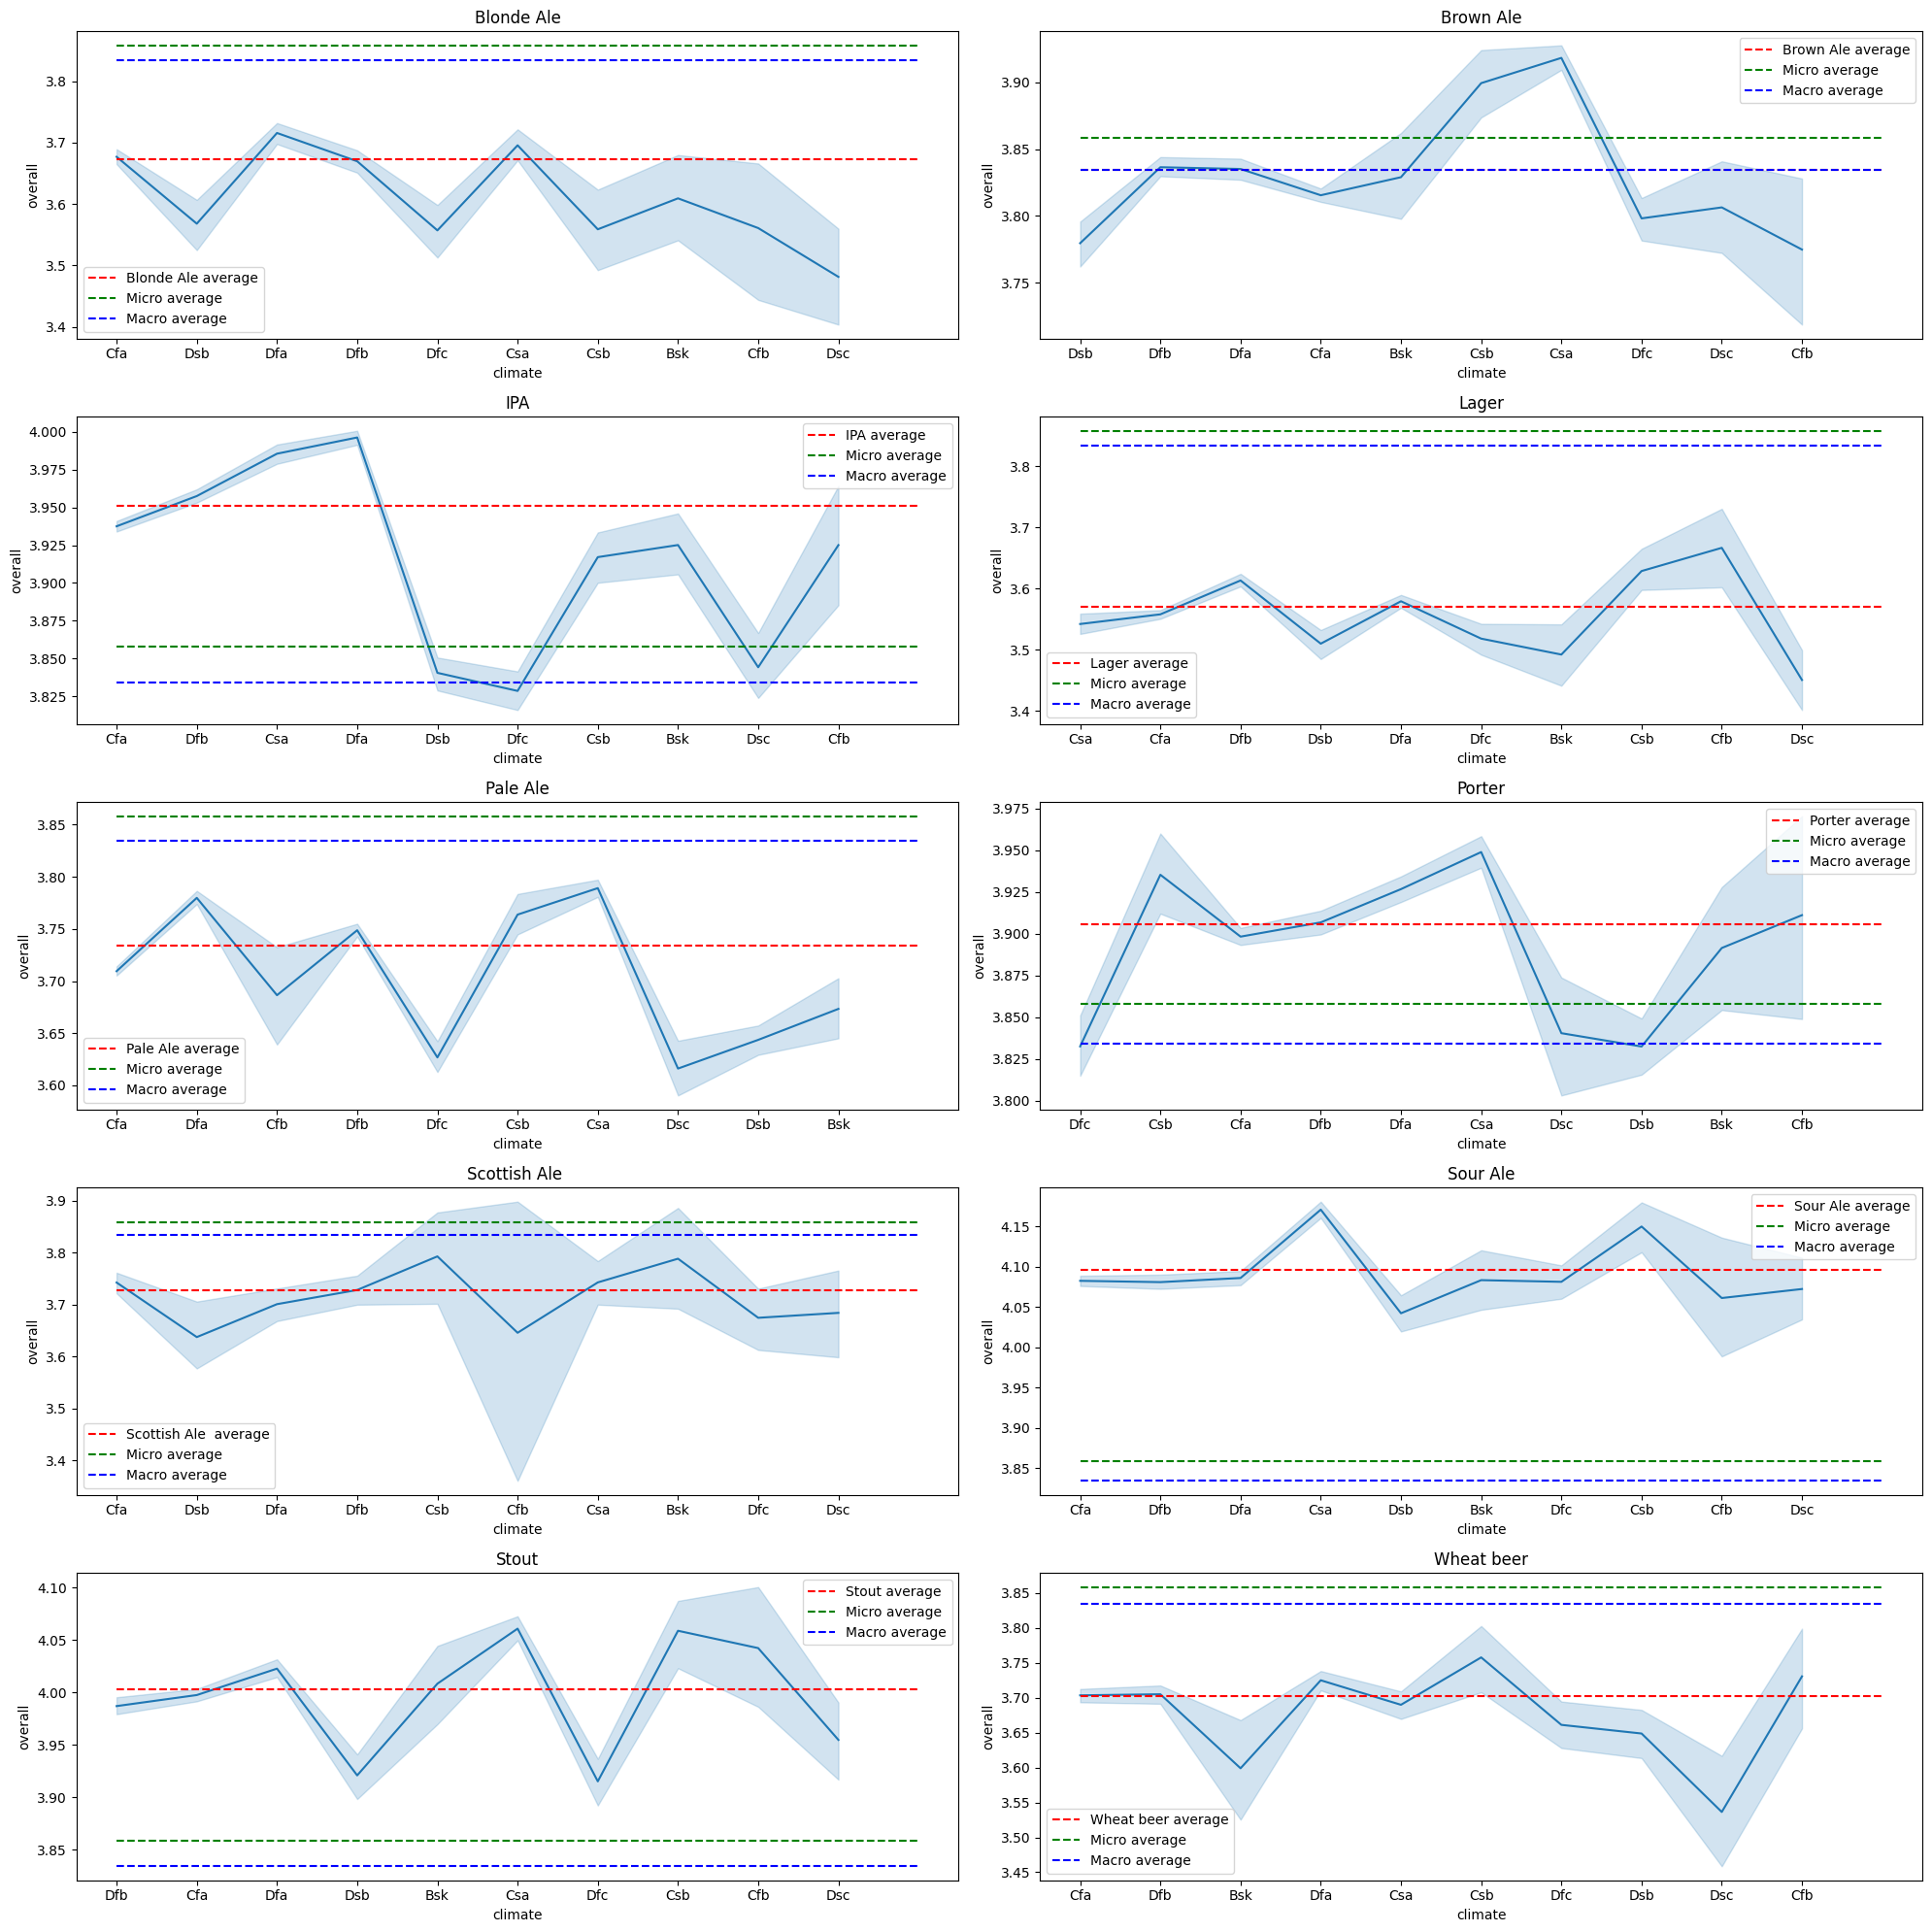

In [66]:
# Plot the different beer type means as a function of the climate for all beers

num_scores = len(climate_beer_type["climate"].unique())
fig, axs = plt.subplots(num_scores // 2, 2, figsize=(20, 20))

for i, beer_type in enumerate(climate_beer_type["general_style"].unique()):
    # compute average beer rating for that beer type
    beer_type_av_overall = us_users_ratings[
        us_users_ratings["general_style"] == beer_type
    ]["overall"].mean()

    # plot the overall beer ratings for each type, climate and the different averagers
    ax = axs[i // 2, i % 2]
    sns.lineplot(
        x="climate",
        y="overall",
        data=us_users_ratings[us_users_ratings["general_style"] == beer_type],
        ax=ax,
    )
    
    ax.set_title(beer_type)
    ax.plot(
        [0, num_scores],
        [beer_type_av_overall, beer_type_av_overall],
        "r--",
        label="{} average".format(beer_type),
    )
    ax.plot(
        [0, num_scores],
        [micro_av_overall, micro_av_overall],
        "g--",
        label="Micro average",
    )
    ax.plot(
        [0, num_scores],
        [macro_av_overall, macro_av_overall],
        "b--",
        label="Macro average",
    )
    ax.legend()

plt.tight_layout()
plt.show()

In [133]:
# Compute a one-way ANOVA test for each beer type to see if the ratings given to each beer type are significantly different
for beer_type in us_users_ratings["general_style"].unique():
    res = stats.f_oneway(
        *[
            us_users_ratings[us_users_ratings["climate"] == climate]["overall"]
            for climate in us_users_ratings["climate"].unique()
        ]
    )
    
    print("For the beer type {}, the p-value is {}".format(beer_type, res.pvalue))

For the beer type Pale Ale, the p-value is 0.0
For the beer type IPA, the p-value is 0.0
For the beer type Porter, the p-value is 0.0
For the beer type Blonde Ale, the p-value is 0.0
For the beer type Scottish Ale , the p-value is 0.0
For the beer type Lager, the p-value is 0.0
For the beer type Wheat beer, the p-value is 0.0
For the beer type Sour Ale, the p-value is 0.0
For the beer type Stout, the p-value is 0.0
For the beer type Brown Ale, the p-value is 0.0


The three averages are:
- beer average: moyenne des averages pour ce type de biere
- macro average: moyenne des averages par climat de toutes les bieres
- micro average: moyenne de tous les averages

It can be noted that the beer macro and micro averages are very similar for Wheat beer, Stout and Lager. This means that the average rating per climate is the same as the average rating overall ie. could be the same distribution or they compensate each other.

Furthermore, From these visualisations, the beers look to be in three main categories:
- beers that are rated better than the micro/macro averages (Stout, Sour Ale)
- beers that are rated better than the micro/macro averages (Wheat Beer,Lager, Blonde Ale, Scottish Ale, Pale Ale)
- beers with ratings that fluctuate around the micro/macro averages (Porter, IPA, Brown Ale)

## Analysis of the beers per sub-climate

As in the score part, we will look at the beers per sub-climate to see if there are any significant differences between the ratings of the beers. For each, we will check the most liked and most reviewed beers.

In [67]:
# Now let's analyse the scheme of the climate and the overall rating
columns = ["climate_scheme"] + ["beer_" + str(i) for i in range(1, 11)]

best_beers_per_climate_scheme = pd.DataFrame(columns=columns)
amount_reviews_per_climate_scheme = pd.DataFrame(columns=columns)

for climate_scheme in us_users_ratings["climate_scheme"].unique():
    row = [climate_scheme] + list(
        us_users_ratings[us_users_ratings["climate_scheme"] == climate_scheme]
        .groupby(["general_style"])["overall"]
        .mean()
        .sort_values(ascending=False)
        .reset_index()["general_style"]
        .values[:10]
    )
    best_beers_per_climate_scheme.loc[len(best_beers_per_climate_scheme)] = row
    amount_reviews_per_climate_scheme.loc[len(amount_reviews_per_climate_scheme)] = [
        climate_scheme
    ] + list(
        us_users_ratings[us_users_ratings["climate_scheme"] == climate_scheme]
        .groupby(["general_style"])["overall"]
        .count()
        .sort_values(ascending=False)
        .reset_index()["overall"]
        .values[:10]
    )

display(best_beers_per_climate_scheme)
display(amount_reviews_per_climate_scheme)

,climate_scheme,beer_1,beer_2,beer_3,beer_4,beer_5,beer_6,beer_7,beer_8,beer_9,beer_10
0,Temperate,Sour Ale,Stout,IPA,Porter,Brown Ale,Scottish Ale,Pale Ale,Wheat beer,Blonde Ale,Lager
1,Continental,Sour Ale,Stout,IPA,Porter,Brown Ale,Pale Ale,Wheat beer,Scottish Ale,Blonde Ale,Lager
2,Dry,Sour Ale,Stout,IPA,Porter,Brown Ale,Scottish Ale,Pale Ale,Blonde Ale,Wheat beer,Lager


,climate_scheme,beer_1,beer_2,beer_3,beer_4,beer_5,beer_6,beer_7,beer_8,beer_9,beer_10
0,Temperate,118267,79628,54961,50771,39179,35466,32429,17208,11077,3920
1,Continental,115496,74989,48768,46117,35882,33047,27276,15328,10154,3225
2,Dry,2777,1826,1050,1008,818,720,656,324,270,102


In [69]:
# For each climate scheme, performe a one-way ANOVA test to see if the ratings given to each beer type are significantly different
for climate_scheme in us_users_ratings["climate_scheme"].unique():
    res = stats.f_oneway(
        *[
            us_users_ratings[us_users_ratings["general_style"] == beer_type]["overall"]
            for beer_type in us_users_ratings["general_style"].unique()
        ]
    )
    
    print("For the climate scheme {}, the p-value is {}".format(climate_scheme, res.pvalue))

For the climate scheme Temperate, the p-value is 0.0
For the climate scheme Continental, the p-value is 0.0
For the climate scheme Dry, the p-value is 0.0


In [135]:
# Let's look at the most reviewed beers for each climate scheme
columns = ["climate_scheme"] + ["beer_" + str(i) for i in range(1, 11)]
most_reviewed_per_climate_scheme = pd.DataFrame(columns=columns)

for climate_scheme in us_users_ratings["climate_scheme"].unique():
    # count the number of reviews for each beer type in this climate
    most_reviewed_per_climate_scheme.loc[climate_scheme] = [climate_scheme] + list(
        us_users_ratings[us_users_ratings["climate_scheme"] == climate_scheme]
        .groupby(["general_style"])
        .size()
        .sort_values(ascending=False)
        .index[:10]
    )
    
display(most_reviewed_per_climate_scheme)

,climate_scheme,beer_1,beer_2,beer_3,beer_4,beer_5,beer_6,beer_7,beer_8,beer_9,beer_10
Temperate,Temperate,IPA,Pale Ale,Brown Ale,Porter,Stout,Lager,Sour Ale,Wheat beer,Blonde Ale,Scottish Ale
Continental,Continental,IPA,Pale Ale,Brown Ale,Porter,Stout,Lager,Sour Ale,Wheat beer,Blonde Ale,Scottish Ale
Dry,Dry,IPA,Pale Ale,Brown Ale,Porter,Stout,Lager,Sour Ale,Wheat beer,Blonde Ale,Scottish Ale


It seems like there are no differences of positions between the beers in the different climate schemes, we look at the precitation and temperature of the climates to see if there are any differences.

In [70]:
# Now let's analyse the precipitation of the climate and the overall rating
columns = ["climate_precipitation"] + ["beer_" + str(i) for i in range(1, 11)]

best_beers_per_climate_precipitation = pd.DataFrame(columns=columns)
amount_reviews_per_climate_precipitation = pd.DataFrame(columns=columns)

for climate_precipitation in us_users_ratings["climate_precipitation"].unique():
    row = [climate_precipitation] + list(
        us_users_ratings[us_users_ratings["climate_precipitation"] == climate_precipitation]
        .groupby(["general_style"])["overall"]
        .mean()
        .sort_values(ascending=False)
        .reset_index()["general_style"]
        .values[:10]
    )
    best_beers_per_climate_precipitation.loc[
        len(best_beers_per_climate_precipitation)
    ] = row
    amount_reviews_per_climate_precipitation.loc[
        len(amount_reviews_per_climate_precipitation)
    ] = [climate_precipitation] + list(
        us_users_ratings[us_users_ratings["climate_precipitation"] == climate_precipitation]
        .groupby(["general_style"])["overall"]
        .count()
        .sort_values(ascending=False)
        .reset_index()["overall"]
        .values[:10]
    )

display(best_beers_per_climate_precipitation)
display(amount_reviews_per_climate_precipitation)

,climate_precipitation,beer_1,beer_2,beer_3,beer_4,beer_5,beer_6,beer_7,beer_8,beer_9,beer_10
0,without dry season,Sour Ale,Stout,IPA,Porter,Brown Ale,Pale Ale,Scottish Ale,Wheat beer,Blonde Ale,Lager
1,with dry season,Sour Ale,Stout,IPA,Porter,Brown Ale,Pale Ale,Scottish Ale,Wheat beer,Blonde Ale,Lager


,climate_precipitation,beer_1,beer_2,beer_3,beer_4,beer_5,beer_6,beer_7,beer_8,beer_9,beer_10
0,without dry season,193030,127289,85636,79826,62664,58322,47270,27701,17874,5822
1,with dry season,43510,29154,19143,18070,13215,13091,10911,5159,3627,1425


In [71]:
# For each climate precipitation, performe a one-way ANOVA test to see if the ratings given to each beer type are significantly different

for climate_precipitation in us_users_ratings["climate_precipitation"].unique():
    res = stats.f_oneway(
        *[
            us_users_ratings[us_users_ratings["general_style"] == beer_type]["overall"]
            for beer_type in us_users_ratings["general_style"].unique()
        ]
    )
    
    print("For the climate precipitation {}, the p-value is {}".format(climate_precipitation, res.pvalue))

For the climate precipitation without dry season, the p-value is 0.0
For the climate precipitation with dry season, the p-value is 0.0


In [136]:
# Let's look at the most reviewed beers for each climate precipitation
columns = ["climate_precipitation"] + ["beer_" + str(i) for i in range(1, 11)]
most_reviewed_per_climate_precipitation = pd.DataFrame(columns=columns)

for climate_precipitation in us_users_ratings["climate_precipitation"].unique():
    # count the number of reviews for each beer type in this climate
    most_reviewed_per_climate_precipitation.loc[
        climate_precipitation
    ] = [climate_precipitation] + list(
        us_users_ratings[us_users_ratings["climate_precipitation"] == climate_precipitation]
        .groupby(["general_style"])
        .size()
        .sort_values(ascending=False)
        .index[:10]
    )
    
display(most_reviewed_per_climate_precipitation)

,climate_precipitation,beer_1,beer_2,beer_3,beer_4,beer_5,beer_6,beer_7,beer_8,beer_9,beer_10
without dry season,without dry season,IPA,Pale Ale,Brown Ale,Porter,Stout,Lager,Sour Ale,Wheat beer,Blonde Ale,Scottish Ale
with dry season,with dry season,IPA,Pale Ale,Brown Ale,Porter,Stout,Sour Ale,Lager,Wheat beer,Blonde Ale,Scottish Ale


Finally, we can look at the average ratings of the beers per climate temperature:

In [72]:
# Now let's analyse the temperature of the climate and the overall rating
columns = ["climate_temperature"] + ["beer_" + str(i) for i in range(1, 11)]

best_beers_per_climate_temperature = pd.DataFrame(columns=columns)
amount_reviews_per_climate_temperature = pd.DataFrame(columns=columns)

for climate_temperature in us_users_ratings["climate_temperature"].unique():
    row = [climate_temperature] + list(
        us_users_ratings[us_users_ratings["climate_temperature"] == climate_temperature]
        .groupby(["general_style"])["overall"]
        .mean()
        .sort_values(ascending=False)
        .reset_index()["general_style"]
        .values[:10]
    )
    best_beers_per_climate_temperature.loc[
        len(best_beers_per_climate_temperature)
    ] = row
    amount_reviews_per_climate_temperature.loc[
        len(amount_reviews_per_climate_temperature)
    ] = [climate_temperature] + list(
        us_users_ratings[us_users_ratings["climate_temperature"] == climate_temperature]
        .groupby(["general_style"])["overall"]
        .count()
        .sort_values(ascending=False)
        .reset_index()["overall"]
        .values[:10]
    )

display(best_beers_per_climate_temperature)
display(amount_reviews_per_climate_temperature)

,climate_temperature,beer_1,beer_2,beer_3,beer_4,beer_5,beer_6,beer_7,beer_8,beer_9,beer_10
0,hot summer,Sour Ale,Stout,IPA,Porter,Brown Ale,Pale Ale,Scottish Ale,Wheat beer,Blonde Ale,Lager
1,warm summer,Sour Ale,Stout,IPA,Porter,Brown Ale,Pale Ale,Scottish Ale,Wheat beer,Blonde Ale,Lager
2,cold summer,Sour Ale,Stout,IPA,Porter,Brown Ale,Scottish Ale,Pale Ale,Wheat beer,Blonde Ale,Lager


,climate_temperature,beer_1,beer_2,beer_3,beer_4,beer_5,beer_6,beer_7,beer_8,beer_9,beer_10
0,hot summer,159978,105150,71037,65445,52281,46810,41979,22548,14917,4855
1,warm summer,65316,43141,28098,27314,20041,19006,15359,8684,5552,1894
2,cold summer,11246,8152,5644,5137,3557,3417,3023,1628,1032,498


In [73]:
# For each climate temperature, performe a one-way ANOVA test to see if the ratings given to each beer type are significantly different

for climate_temperature in us_users_ratings["climate_temperature"].unique():
    res = stats.f_oneway(
        *[
            us_users_ratings[us_users_ratings["general_style"] == beer_type]["overall"]
            for beer_type in us_users_ratings["general_style"].unique()
        ]
    )
    
    print("For the climate temperature {}, the p-value is {}".format(climate_temperature, res.pvalue))

For the climate temperature hot summer, the p-value is 0.0
For the climate temperature warm summer, the p-value is 0.0
For the climate temperature cold summer, the p-value is 0.0


In [137]:
# Let's look at the most reviewed beers for each climate temperature
columns = ["climate_temperature"] + ["beer_" + str(i) for i in range(1, 11)]
most_reviewed_per_climate_temperature = pd.DataFrame(columns=columns)

for climate_temperature in us_users_ratings["climate_temperature"].unique():
    # count the number of reviews for each beer type in this climate
    most_reviewed_per_climate_temperature.loc[
        climate_temperature
    ] = [climate_temperature] + list(
        us_users_ratings[us_users_ratings["climate_temperature"] == climate_temperature]
        .groupby(["general_style"])
        .size()
        .sort_values(ascending=False)
        .index[:10]
    )
    
display(most_reviewed_per_climate_temperature)

,climate_temperature,beer_1,beer_2,beer_3,beer_4,beer_5,beer_6,beer_7,beer_8,beer_9,beer_10
hot summer,hot summer,IPA,Pale Ale,Brown Ale,Porter,Stout,Lager,Sour Ale,Wheat beer,Blonde Ale,Scottish Ale
warm summer,warm summer,IPA,Pale Ale,Brown Ale,Porter,Stout,Lager,Sour Ale,Wheat beer,Blonde Ale,Scottish Ale
cold summer,cold summer,IPA,Pale Ale,Brown Ale,Porter,Stout,Lager,Sour Ale,Wheat beer,Blonde Ale,Scottish Ale


There is no clear pattern between the beers and the climates, so we can conclude that the climate does not have a significant impact on the kind of beers liked.

We will also look at the original `style` column to see if there are any differences between the beers in the different climates.

In [78]:
# Now let's analyse the scheme of the climate and the overall rating
columns = ["climate_scheme"] + ["beer_" + str(i) for i in range(1, 6)]

best_beers_per_climate_scheme = pd.DataFrame(columns=columns)
amount_reviews_per_climate_scheme = pd.DataFrame(columns=columns)

for climate_scheme in us_users_ratings["climate_scheme"].unique():
    row = [climate_scheme] + list(
        us_users_ratings[us_users_ratings["climate_scheme"] == climate_scheme]
        .groupby(["style"])["overall"]
        .mean()
        .sort_values(ascending=False)
        .reset_index()["style"]
        .values[:5]
    )
    best_beers_per_climate_scheme.loc[len(best_beers_per_climate_scheme)] = row
    amount_reviews_per_climate_scheme.loc[len(amount_reviews_per_climate_scheme)] = [
        climate_scheme
    ] + list(
        us_users_ratings[us_users_ratings["climate_scheme"] == climate_scheme]
        .groupby(["style"])["overall"]
        .count()
        .sort_values(ascending=False)
        .reset_index()["overall"]
        .values[:5]
    )

display(best_beers_per_climate_scheme)
display(amount_reviews_per_climate_scheme)

,climate_scheme,beer_1,beer_2,beer_3,beer_4,beer_5
0,Temperate,Gueuze,Quadrupel (Quad),Lambic - Fruit,American Double / Imperial Stout,American Wild Ale
1,Continental,Gueuze,Quadrupel (Quad),Lambic - Fruit,American Double / Imperial IPA,American Double / Imperial Stout
2,Dry,Faro,Gueuze,Euro Strong Lager,Lambic - Fruit,Quadrupel (Quad)


,climate_scheme,beer_1,beer_2,beer_3,beer_4,beer_5
0,Temperate,58948,39742,25068,24087,20375
1,Continental,55754,41413,25726,21208,16869
2,Dry,1489,821,556,430,428


In [79]:
# Now let's analyse the precipitation of the climate and the overall rating
columns = ["climate_precipitation"] + ["beer_" + str(i) for i in range(1, 6)]

best_beers_per_climate_precipitation = pd.DataFrame(columns=columns)
amount_reviews_per_climate_precipitation = pd.DataFrame(columns=columns)

for climate_precipitation in us_users_ratings["climate_precipitation"].unique():
    row = [climate_precipitation] + list(
        us_users_ratings[us_users_ratings["climate_precipitation"] == climate_precipitation]
        .groupby(["style"])["overall"]
        .mean()
        .sort_values(ascending=False)
        .reset_index()["style"]
        .values[:5]
    )
    best_beers_per_climate_precipitation.loc[
        len(best_beers_per_climate_precipitation)
    ] = row
    amount_reviews_per_climate_precipitation.loc[
        len(amount_reviews_per_climate_precipitation)
    ] = [climate_precipitation] + list(
        us_users_ratings[us_users_ratings["climate_precipitation"] == climate_precipitation]
        .groupby(["style"])["overall"]
        .count()
        .sort_values(ascending=False)
        .reset_index()["overall"]
        .values[:5]
    )

display(best_beers_per_climate_precipitation)
display(amount_reviews_per_climate_precipitation)

,climate_precipitation,beer_1,beer_2,beer_3,beer_4,beer_5
0,without dry season,Gueuze,Quadrupel (Quad),Lambic - Fruit,American Double / Imperial IPA,American Double / Imperial Stout
1,with dry season,Gueuze,Lambic - Fruit,Quadrupel (Quad),American Double / Imperial Stout,American Wild Ale


,climate_precipitation,beer_1,beer_2,beer_3,beer_4,beer_5
0,without dry season,92956,68279,41627,37094,29014
1,with dry season,23235,13697,9612,8742,8658


In [80]:
# Now let's analyse the temperature of the climate and the overall rating
columns = ["climate_temperature"] + ["beer_" + str(i) for i in range(1, 6)]

best_beers_per_climate_temperature = pd.DataFrame(columns=columns)
amount_reviews_per_climate_temperature = pd.DataFrame(columns=columns)

for climate_temperature in us_users_ratings["climate_temperature"].unique():
    row = [climate_temperature] + list(
        us_users_ratings[us_users_ratings["climate_temperature"] == climate_temperature]
        .groupby(["style"])["overall"]
        .mean()
        .sort_values(ascending=False)
        .reset_index()["style"]
        .values[:5]
    )
    best_beers_per_climate_temperature.loc[
        len(best_beers_per_climate_temperature)
    ] = row
    amount_reviews_per_climate_temperature.loc[
        len(amount_reviews_per_climate_temperature)
    ] = [climate_temperature] + list(
        us_users_ratings[us_users_ratings["climate_temperature"] == climate_temperature]
        .groupby(["style"])["overall"]
        .count()
        .sort_values(ascending=False)
        .reset_index()["overall"]
        .values[:5]
    )
    
display(best_beers_per_climate_temperature)
display(amount_reviews_per_climate_temperature)

,climate_temperature,beer_1,beer_2,beer_3,beer_4,beer_5
0,hot summer,Gueuze,Quadrupel (Quad),Lambic - Fruit,American Double / Imperial Stout,American Double / Imperial IPA
1,warm summer,Gueuze,Quadrupel (Quad),Lambic - Fruit,American Double / Imperial IPA,Lambic - Unblended
2,cold summer,Gueuze,Lambic - Fruit,Quadrupel (Quad),American Double / Imperial Stout,American Wild Ale


,climate_temperature,beer_1,beer_2,beer_3,beer_4,beer_5
0,hot summer,77389,56663,33973,32056,26206
1,warm summer,32697,22288,14123,11994,9524
2,cold summer,6105,3025,2656,2273,1942


Again, there is almost no variability between the beers in the different climates, so we can conclude that the climate does not have a significant impact on the kind of beers liked.

This leads us to investigate again on why the ratings of the different beers are so different. We will look at the alcohol percentage of the beers to see if there is a correlation between the alcohol percentage and the ratings. Let's take a look at the abv per beer style:

In [91]:
# keep only the beers which have an abv between 0 and 95% (to remove outliers)
quantile_5 = us_users_ratings["abv"].quantile(0.05)
quantile_95 = us_users_ratings["abv"].quantile(0.95)

print("5th percentile:", quantile_5)
print("95th percentile:", quantile_95)

us_abv_ratings = us_users_ratings[
    (us_users_ratings["abv"] >= quantile_5) & (us_users_ratings["abv"] <= quantile_95)
]

5th percentile: 4.5
95th percentile: 11.0


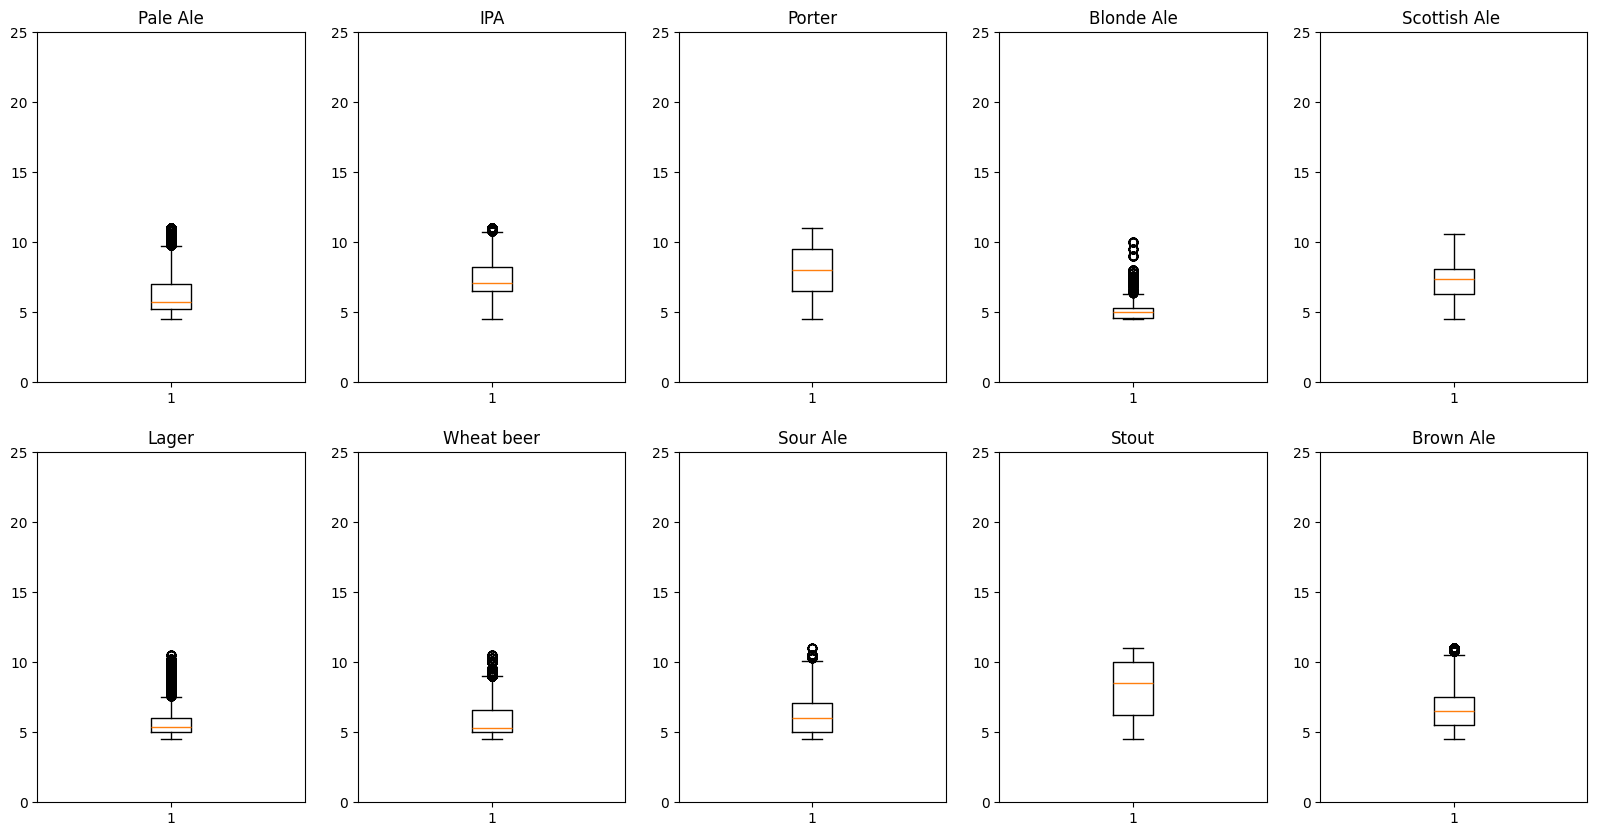

In [104]:
# boxplot of abv for each general beer type

fig, axs = plt.subplots(2, 5, figsize=(20, 10))

for i, beer_type in enumerate(general_beer_types):
    # general_beer_type = general_beer_types[i]
    ax = axs[i // 5, i % 5]
    general_beer_type_df = us_abv_ratings[
        us_abv_ratings["general_style"] == beer_type
    ]
    ax.boxplot(general_beer_type_df["abv"])
    ax.set_title(beer_type)
    # set y axis limits
    ax.set_ylim(0, 25)

plt.savefig("abv_boxplot_styles.png", dpi=600)
plt.show()

We will try to plot them nicely:

In [105]:
# For each beer type, find the 25th and 75th percentile of the abv
abv_percentiles_per_beer_type = {}
for beer_type in general_beer_types:
    abv_percentiles_per_beer_type[beer_type] = us_abv_ratings[
        us_abv_ratings["general_style"] == beer_type
    ]["abv"].quantile([0.25, 0.75]).values
    
print("The 25th and 75th percentiles of the abv for each beer type are:")
print(abv_percentiles_per_beer_type)

The 25th and 75th percentiles of the abv for each beer type are:
{'Pale Ale': array([5.2, 7. ]), 'IPA': array([6.5, 8.2]), 'Porter': array([6.5, 9.5]), 'Blonde Ale': array([4.6, 5.3]), 'Scottish Ale ': array([6.3, 8.1]), 'Lager': array([5., 6.]), 'Wheat beer': array([5. , 6.6]), 'Sour Ale': array([5. , 7.1]), 'Stout': array([ 6.2, 10. ]), 'Brown Ale': array([5.5, 7.5])}


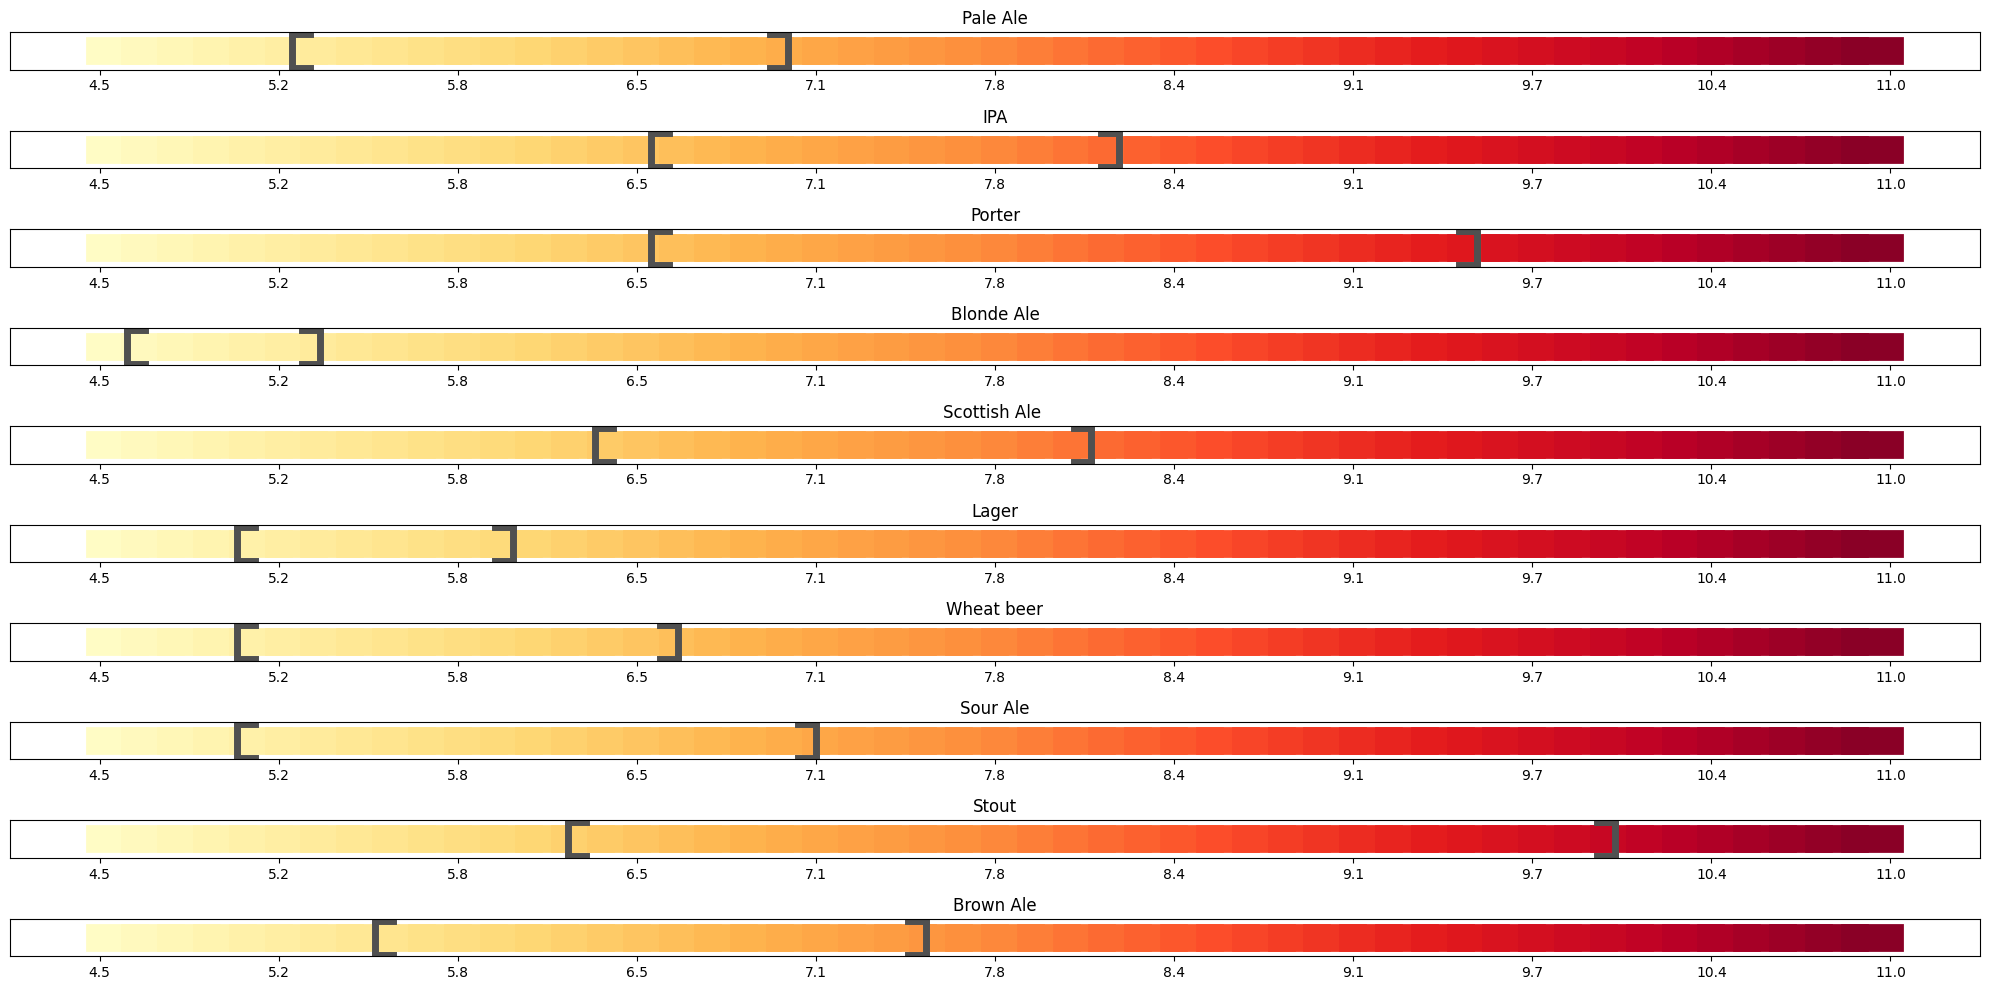

In [132]:
# For each beer type, plot a color line where the min and max limits are the 5th and 95th percentiles of the abv for all beers
# then plot square brackets at the 25th and 75th percentiles of the abv for each beer type

fig, ax = plt.subplots(len(general_beer_types), figsize=(20, 10))

min_abv = quantile_5
max_abv = quantile_95

slope_abv_to_x = 1 / (max_abv - min_abv)
intercept_abv_to_x = - min_abv / (max_abv - min_abv)


for i, beer_type in enumerate(general_beer_types):
    
    
    N = 50
    base_colors = sns.color_palette("YlOrRd", N)
    
    for j in range(N):
        ax[i].plot([j/N, (j+1)/N], [0, 0], lw=20, c=base_colors[j])

    # Plot brackets at each end
    x_25th = slope_abv_to_x * abv_percentiles_per_beer_type[beer_type][0] + intercept_abv_to_x
    x_75th = slope_abv_to_x * abv_percentiles_per_beer_type[beer_type][1] + intercept_abv_to_x
    
    line_color = "#505050"
    ax[i].plot([x_25th, x_25th], [-0.5, 0.5], lw=5, c=line_color)
    ax[i].plot([x_25th, x_25th+0.01], [-0.5, -0.5], lw=5, c=line_color)
    ax[i].plot([x_25th, x_25th+0.01], [0.5, 0.5], lw=5, c=line_color)
    
    ax[i].plot([x_75th, x_75th], [-0.5, 0.5], lw=5, c=line_color)
    ax[i].plot([x_75th-0.01, x_75th], [-0.5, -0.5], lw=5, c=line_color)
    ax[i].plot([x_75th-0.01, x_75th], [0.5, 0.5],lw=5, c=line_color)
    
    ax[i].set_title(beer_type)
    ax[i].set_yticks([])
    ax[i].set_xticks(np.arange(0, 1.1, 0.1))
    ax[i].set_xticklabels(np.arange(min_abv, max_abv+((max_abv-min_abv)/10).round(1), (max_abv-min_abv)/10).round(1))

plt.tight_layout()
plt.show()

We see that even in one style of beer, there is a lot of variability in the alcohol percentage. We will look at the alcohol percentage of the beers in the different climates to see if there is a correlation between the alcohol percentage and the ratings.